# Introduction

Thank you for your time dedicated to review this project. Please consider the points as follows prior to start running the code:

*   Before running the code, please upload the 3 .json files provided in the Github repository. (https://github.com/Bernard-aiTech/Customer_Promotion_Analysis.git)
*   After that the whole code is run, please click on the public URL generated in the first part of this document. The application will be ready then in a new window.

# Generate A Public URL

In [4]:
# The public URL generated in this part is mapped into the http://127.0.0.1:8050

from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(8050)"))

https://bu1iixw9g3c-496ff2e9c6d22116-8050-colab.googleusercontent.com/


# Install Required Libraries

In [1]:
!pip install dash dash-bootstrap-components pyngrok pandas scikit-learn numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.5/222.5 kB 19.3 MB/s eta 0:00:00


# Develop Application Structure

Optimum number of clusters is  4
               accuracy  precision    recall  f1_score
Naive Bayes    0.962375   0.962375  0.962375  0.962375
Random Forest  0.999655   0.999655  0.999655  0.999655
XGBoost        1.000000   1.000000  1.000000  1.000000


<IPython.core.display.Javascript object>

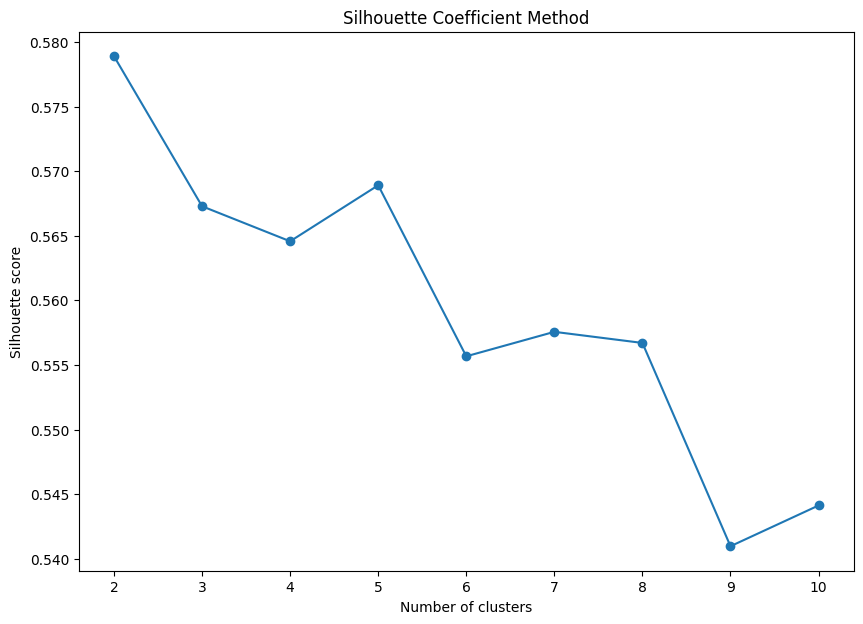

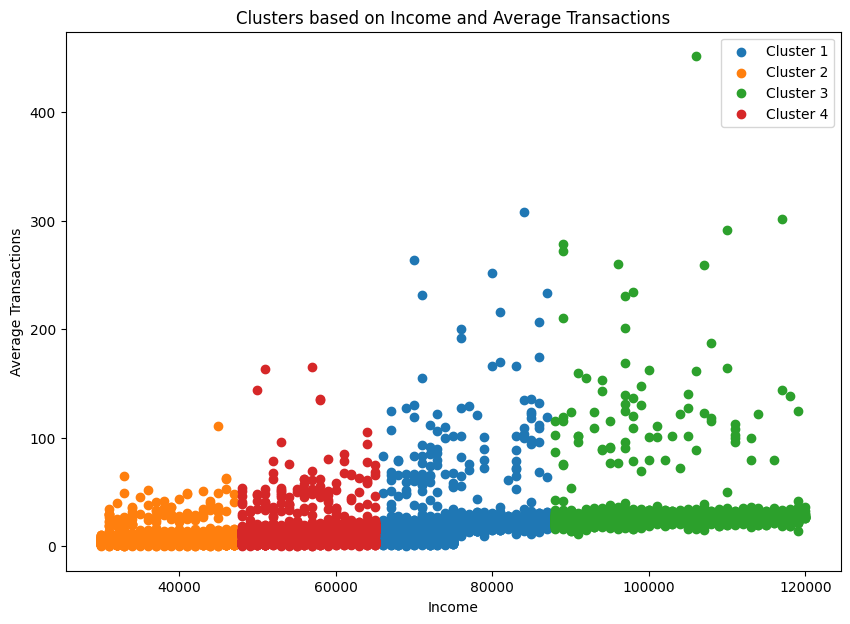

In [6]:
# Import required components
import numpy as np
from pyngrok import ngrok
import json
import pandas as pd
import dash
from dash import dcc, html
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output, State
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import base64
from io import BytesIO

# JSON Data Loader Class
class JSONDataLoader:
    def __init__(self, portfolio_path, profile_path, transcript_path):
        self.portfolio_path = portfolio_path
        self.profile_path = profile_path
        self.transcript_path = transcript_path

    # Read the .json files
    def read_json_file(self, file_path):
        with open(file_path, 'r') as file:
            data = [json.loads(line) for line in file if line.strip()]
        return pd.DataFrame(data)

    # Create a dataframe from the .json files
    def create_dataframe_from_transcript(self):
        transcript_df = self.read_json_file(self.transcript_path)
        portfolio_df = self.read_json_file(self.portfolio_path)
        profile_df = self.read_json_file(self.profile_path)

        # Extract offer_id and transaction amount before dropping 'value' column
        transcript_df['offer_id'] = transcript_df['value'].apply(lambda x: x.get('offer_id') or x.get('offer id'))
        transcript_df['transaction_amount'] = transcript_df['value'].apply(lambda x: x.get('amount'))
        transcript_df['transaction_amount'] = transcript_df['transaction_amount'].astype(float)
        transcript_df = transcript_df.drop(columns=['value'])
        transcript_df['transaction_amount'].fillna(0.0001, inplace=True)

        # Create different measured tables (_1 to _6) from transcript_df to transform information required for the analysis
        transcript_df_1 = transcript_df.groupby(['person', 'event'])['transaction_amount'].sum().reset_index()
        transcript_df_6 = transcript_df[transcript_df['transaction_amount'] > 0.0001].groupby(['person'])['transaction_amount'].count().reset_index()

        # Pivot the transcript DataFrame
        transcript_df_pivot = transcript_df_1.pivot(index='person', columns='event', values='transaction_amount').reset_index()

        # Rename columns to make it more clear
        transcript_df_pivot.rename(columns={'offer received': 'offer_received'}, inplace=True)
        transcript_df_pivot.rename(columns={'offer viewed': 'offer_viewed'}, inplace=True)
        transcript_df_pivot.rename(columns={'offer completed': 'offer_completed'}, inplace=True)

        # Convert transaction_amount to float
        transcript_df_pivot['offer_received'] = transcript_df_pivot['offer_received'] * 10000
        transcript_df_pivot['offer_viewed'] = transcript_df_pivot['offer_viewed'] * 10000
        transcript_df_pivot['offer_completed'] = transcript_df_pivot['offer_completed'] * 10000

        # Fill missing values with 0
        for col in ['offer_received', 'offer_viewed', 'offer_completed']:
            transcript_df_pivot[col] = transcript_df_pivot[col].fillna(0)

        # Use a list to select multiple columns
        transcript_df_2 = transcript_df.merge(portfolio_df[['reward','difficulty','duration','id']], left_on='offer_id', right_on='id', how='left')

        # Handle duplicate 'person' entries before pivoting
        transcript_df_3 = transcript_df_2.groupby(['person'])['reward'].mean().reset_index()
        transcript_df_4 = transcript_df_2.groupby(['person'])['difficulty'].mean().reset_index()
        transcript_df_5 = transcript_df_2.groupby(['person'])['duration'].mean().reset_index()

        # Aggregate the measured tables
        transcript_df_pivot = transcript_df_pivot.merge(transcript_df_3, on='person', how='left')
        transcript_df_pivot = transcript_df_pivot.merge(transcript_df_4, on='person', how='left')
        transcript_df_pivot = transcript_df_pivot.merge(transcript_df_5, on='person', how='left')
        transcript_df_pivot = transcript_df_pivot.merge(transcript_df_6, on='person', how='left')

        # Rename columns to make it more clear
        transcript_df_pivot.rename(columns={'transaction_amount': '#_transaction'}, inplace=True)
        profile_df.rename(columns={'id': 'customer_id'}, inplace=True)

        # Merge profile_df and transcript_df_pivot based on 'customer_id'
        df = profile_df.merge(transcript_df_pivot, left_on='customer_id', right_on='person', how='left')

        # Clean up the df
        df = df.drop(columns=['person'])
        df = df[profile_df['age'] != 118]
        df = df.drop_duplicates().reset_index(drop=True)

        df['gender'] = df['gender'].astype('category')
        df['age'] = df['age'].astype('int')
        df['customer_id'] = df['customer_id'].astype('string')
        df['income'] = df['income'].astype('float64')

        # Convert 'became_member_on' to datetime before using .dt accessor
        df['became_member_on'] = pd.to_datetime(df['became_member_on'])

        df['membership_year'] = df['became_member_on'].dt.year
        df['membership_month'] = df['became_member_on'].dt.month
        df['membership_day'] = df['became_member_on'].dt.day
        df = df.drop(columns=['became_member_on'])

        # Replace the abbreviations with the original names
        gender_map = {'M': 'Male', 'F': 'Female', 'O': 'Other'}
        df['gender'] = df['gender'].map(gender_map)
        for col in df.select_dtypes(include=['category']):
            df[col] = df[col].cat.add_categories('Unknown').fillna('Unknown')

        # Rename columns to make it more clear
        df.rename(columns={'offer_completed': '#_offer_completed'}, inplace=True)
        df.rename(columns={'offer_viewed': '#_offer_viewedd'}, inplace=True)
        df.rename(columns={'offer_received': '#_offer_received'}, inplace=True)
        df.rename(columns={'transaction': 'sum_transaction'}, inplace=True)
        df.rename(columns={'reward': 'avrg_reward'}, inplace=True)
        df.rename(columns={'difficulty': 'avrg_difficulty'}, inplace=True)
        df.rename(columns={'duration': 'avrg_duration'}, inplace=True)

        # Add a new column as 'age_bucket', and assign a bucket code based on the histogram of the 'age' column
        bins = [18, 25, 35, 45, 55, 65, 100]
        labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
        df['age_bucket'] = pd.cut(df['age'], bins=bins, labels=labels, include_lowest=True)

        # Create a new column 'age_median' and calculate the median of each age bin
        df['age_median'] = df.groupby('age_bucket')['age'].transform('median')

        df = df.dropna()

        # Calculate the average transaction amount
        df['avrg_transaction'] = df['sum_transaction'] / df['#_transaction']
        df['avrg_transaction'] = df['avrg_transaction'].fillna(0)

        return df

# Load data
data_loader = JSONDataLoader('portfolio.json', 'profile.json', 'transcript.json')
df = data_loader.create_dataframe_from_transcript()

# Calculate silhouette scores for different numbers of clusters
selected_cols = ['age', 'income', '#_offer_completed', 'avrg_reward', 'avrg_difficulty', 'avrg_duration', 'avrg_transaction']

silhouettes = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df[selected_cols])
    silhouettes.append(silhouette_score(df[selected_cols], kmeans.labels_))

# Visualize the silhouette scores for different numbers of clusters
plt.figure(figsize=(10, 7))
plt.plot(range(2, 11), silhouettes, marker='o')
plt.title('Silhouette Coefficient Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')

# Find the optimal number of clusters
opt_silhouette_index = 0
score_silhouette = silhouettes[0]
for i in range(1, 6):
    if silhouettes[i] < score_silhouette and silhouettes[i] < silhouettes[i+1]:
        score_silhouette = silhouettes[i]
        opt_silhouette_index = i

print("Optimum number of clusters is ", opt_silhouette_index)

# Cluster the customers based on the optimal number of clusters
kmeans = KMeans(n_clusters=opt_silhouette_index, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(df[selected_cols])
df['cluster'] = kmeans.labels_

# Plot the clusters based on the 'income' and 'avrg_transaction'
plt.figure(figsize=(10, 7))
for i in range(opt_silhouette_index):
    cluster_data = df[df['cluster'] == i]
    plt.scatter(cluster_data['income'], cluster_data['avrg_transaction'], label=f'Cluster {i + 1}')
plt.xlabel('Income')
plt.ylabel('Average Transactions')
plt.title('Clusters based on Income and Average Transactions')
plt.legend()

# Create visualizations
hist_age = px.histogram(df, x="age", template="plotly_dark")
hist_income = px.histogram(df, x="income", template="plotly_dark")
pie_gender = px.pie(df, names="gender", template="plotly_dark")
pie_cluster = px.pie(df, names="cluster", template="plotly_dark")

# Set the 'cluster' as the target variable
target_variable = 'cluster'

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df[selected_cols], df[target_variable], test_size=0.2, random_state=42)

# Create a list to store the models
models = []

# Create a Naive Bayes model
nb_model = GaussianNB()
models.append(('Naive Bayes', nb_model))

# Create a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
models.append(('Random Forest', rf_model))

# Create a XGBoost model
xgb_model = XGBClassifier(n_estimators=100, max_depth=5, random_state=42)
models.append(('XGBoost', xgb_model))

# Train each model on the training data
for name, model in models:
    model.fit(X_train, y_train)

# Evaluate the models' performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create a list to store the metrics
metrics = ['accuracy', 'precision', 'recall', 'f1_score']

# Create a dictionary to store the results
results = {}

# Iterate through each model
for name, model in models:
    # Predict the labels for the validation set
    y_pred = model.predict(X_val)

    # Calculate the metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='micro')
    recall = recall_score(y_val, y_pred, average='micro')
    f1 = f1_score(y_val, y_pred, average='micro')

    # Store the results in the dictionary
    results[name] = [accuracy, precision, recall, f1]

# Create a pivot table from the results dictionary
# Set the model names as the index
df_results = pd.DataFrame.from_dict(results, orient='index', columns=metrics)

# Print the pivot table
print(df_results)

# Calculate pivot table for clusters
pivot_table = df.groupby('cluster').agg({
    'avrg_reward': ['mean', 'std'],
    'avrg_difficulty': ['mean', 'std'],
    'avrg_duration': ['mean', 'std'],
    'avrg_transaction': ['mean', 'std']
}).reset_index()

# Round the values in the pivot table
pivot_table = pivot_table.round(3)

pivot_table.columns = ['Cluster', 'Avrg Reward', 'StdVar Reward', 'Avrg Difficulty', 'StdVar Difficulty',
                       'Avrg Duration', 'StdVar Duration', 'Avrg Transaction', 'StdVar Transaction']

# Calculate the mean values for the missing features from your training data
mean_offer_completed = X_train['#_offer_completed'].mean()
mean_difficulty = X_train['avrg_difficulty'].mean()
mean_duration = X_train['avrg_duration'].mean()
mean_transaction = X_train['avrg_transaction'].mean()
mean_reward = X_train['avrg_reward'].mean()

# Build App
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.DARKLY])

custom_styles = {
    "input-div": {
        "margin-bottom": "20px",
        "margin-top": "10px",
        "padding": "10px",
        "border": "1px solid #ccc",
        "border-radius": "7px",
        "background-color": "#2a2a2a"
    },
    "result-div": {
        "margin-bottom": "20px",
        "margin-top": "10px",
        "padding": "10px",
        "border": "1px solid #ccc",
        "border-radius": "7px",
        "background-color": "#2a2a2a",
#        "color": "white"
    },
    "header": {
        "margin-top": "7px",
        "color": "white"
    },
    "label": {
        "color": "white"
    }
}

# Define the layout of the app
app.layout = dbc.Container([
    dbc.Row([
        dbc.Col([
            html.H1("Customer Segmentation & Promotion Analytics", style=custom_styles["header"])
        ], width=12)
    ]),
    dbc.Tabs([
        dbc.Tab(label="Insight", tab_id="model-tab", children=[
            dbc.Row([
                dbc.Col([
                    html.H3("Age Distribution", style=custom_styles["header"]),
                    dcc.Graph(figure=hist_age, style={"width": "100%", "border-radius": "7px"})
                ], width=6),
                dbc.Col([
                    html.H3("Income Distribution", style=custom_styles["header"]),
                    dcc.Graph(figure=hist_income, style={"width": "100%", "border-radius": "7px"})
                ], width=6)
            ]),
            dbc.Row([
                dbc.Col([
                    html.H3("Gender Distribution", style=custom_styles["header"]),
                    dcc.Graph(figure=pie_gender, style={"width": "100%", "border-radius": "7px"})
                ], width=6),
                dbc.Col([
                    html.H3("Cluster Distribution", style=custom_styles["header"]),
                    dcc.Graph(figure=pie_cluster, style={"width": "100%", "border-radius": "7px"})
                ], width=6)
            ]),
        ]),
        dbc.Tab(label="Prediction", tab_id="prediction-tab", children=[
            dbc.Row([
                dbc.Col([
                    html.H4("Please specify your target market for this promotion:", style=custom_styles["header"]),
html.P("What are the customers' AGE and INCOME for whom this promotion is designed?", style=custom_styles["header"]),
                    html.Div([
                        html.Label("Age: ", style=custom_styles["label"]),
                        dcc.Input(id="age-input", type="number", placeholder="Enter age", style={"border-radius": "5px"}),
], style=custom_styles["input-div"]),
                    html.Div([
                        html.Label("Income: ", style=custom_styles["label"]),
                        dcc.Input(id="income-input", type="number", placeholder="Enter income", style={"border-radius": "5px"}),
                    ], style=custom_styles["input-div"]),
                    html.Button("Predict", id="submit-button", n_clicks=0, style={'width': '90px', 'height': '45px', 'margin-bottom': '5px', "border-radius": "5px"}),
                ], width=6),
            ]),
            dbc.Row([
                dbc.Col([
                    html.H4("Your customers targeted for this promotion are segmented based on Machine Learning models:", style=custom_styles["header"]),
                    html.Div(id="output-cluster", style=custom_styles["result-div"])
                ], width=12)
            ]),
            dbc.Row([
                dbc.Col([
                    html.H4("It means, regarding the analysis conducted, the parameters of this promotion are suggested to be designed as follows:", style=custom_styles["header"]),
                    html.Div(id="promotion-design", style=custom_styles["result-div"])
                ], width=12)
            ])
        ])
    ])
])

# Define the callback to update the output
@app.callback(
    [Output("output-cluster", "children"),
     Output("promotion-design", "children")],
    [Input("submit-button", "n_clicks")],
    [State("age-input", "value"),
     State("income-input", "value")]
)
def update_output(n_clicks, age, income):
    if n_clicks > 0 and age is not None and income is not None:
        new_row = {'age': age, 'income': income, '#_offer_completed': mean_offer_completed,
                   'avrg_reward': mean_reward, 'avrg_difficulty': mean_difficulty, 'avrg_duration': mean_duration,
                   'avrg_transaction': mean_transaction}
        new_row_df = pd.DataFrame([new_row])

        # Use the Random Forest model to predict the cluster
        predicted_cluster = rf_model.predict(new_row_df)[0]

        # Get the statistics for the predicted cluster
        cluster_stats = pivot_table[pivot_table['Cluster'] == predicted_cluster].iloc[0]

        duration_interval = (round(cluster_stats['Avrg Duration'] - cluster_stats['StdVar Duration'],2),
                             round(cluster_stats['Avrg Duration'] + cluster_stats['StdVar Duration'],2))
        difficulty_interval = (round(cluster_stats['Avrg Difficulty'] - cluster_stats['StdVar Difficulty'],2),
                               round(cluster_stats['Avrg Difficulty'] + cluster_stats['StdVar Difficulty'],2))
        reward_interval = (round(cluster_stats['Avrg Reward'] - cluster_stats['StdVar Reward'],2),
                           round(cluster_stats['Avrg Reward'] + cluster_stats['StdVar Reward'],2))
        transaction_interval = (round(cluster_stats['Avrg Transaction'] - cluster_stats['StdVar Transaction'],2),
                                round(cluster_stats['Avrg Transaction'] + cluster_stats['StdVar Transaction'],2))

        prediction_text = f"The cluster predicted for this segment of customers: {predicted_cluster}"

        promotion_design = [
            html.Div(f"Duration interval in DAYS considered to be open for this offer: {duration_interval}"),
            html.Div(f"Difficulty interval in $ required to complete this offer: {difficulty_interval}"),
            html.Div(f"Reward interval in POINTS given to complete this offer: {reward_interval}"),
            html.Div(f"Transaction interval in $ predicted to spend for this offer: {transaction_interval}")
        ]

        return prediction_text, promotion_design
    else:
        return "Enter values and press submit", ""

# Run app and display result
if __name__ == '__main__':
    app.run_server(debug=True)
